# Point-wise missing pattern
We will now look at the imputation problem for missing values in more detail. In particular, we will see how to format the data for the $\texttt{FIM-}\ell$ model, an example of higher dimensional data as well as some more advanced ways of interacting with our model. We once again start by loading the pretrained model and extracting $\texttt{FIM-}\ell$:

In [1]:
from fim.models.imputation import FIMImputationWindowed
import torch
model = FIMImputationWindowed.from_pretrained("FIM4Science/fim-windowed-imputation")
base_model=model.fim_imputation.fim_base

## Imputing point-wise missing values on a fine grid
Now we once again generate our simple polynomial data:

In [2]:
ts = (torch.arange(0, 10, step=0.1) - 3).reshape(1, 100, 1)
true_values = torch.square(ts) - ts 
observed_values = true_values + torch.normal(0, 2.5, size=true_values.shape)

To explain how you should format your own data when interacting with $\texttt{FIM-}\ell$, we will now write the previously imported ```prepare_data_base```
function ourselves. Luckily this is not much work in for this model!

To summarize, the model takes a dict as input, which elements the following shapes:
|  Key  | Shape | Remark |
| ----- | ----- | ------ |
| coarse_grid_noisy_sample_paths | [B, T, 1] | |
| coarse_grid_grid | [B, T, 1] | |
| coarse_grid_noisy_observation_mask | [B, T, 1] | |
| coarse_grid_grid | [B, T, 1] | |
| fine_grid_grid | [B, L, 1] | |
| fine_grid_sample_paths | [B, L, 1] | if available, used to compute errors |

In [3]:
def prepare_data_base(ts, values, mask=None, fine_grid_times=None):
    """
    Prepare data for the base FIM-imputation-base model.
    
    Args:
        ts: Time points tensor of shape [B, T, 1]  
        values: Value tensor of shape [B, T, 1]
        mask: Boolean mask tensor of shape [B, T, 1] (True = missing, False = observed)
        fine_grid_times: Fine grid for evaluation, if None uses same as ts
        
    Returns:
        batch: Dictionary suitable for base FIM-imputation-base model
    """
    if mask is None:
        mask = torch.zeros_like(ts).bool() # If no mask is given, all data was observed
    
    if fine_grid_times is None:
        fine_grid_times = ts.clone()
    
    # The model FIM-imputation-base expects this format based on its forward method
    batch = {
        # Coarse grid (observations)
        "coarse_grid_noisy_sample_paths": values,  # [B, T, 1]
        "coarse_grid_grid": ts,                    # [B, T, 1] 
        "coarse_grid_observation_mask": mask,      # [B, T, 1]
        
        # Fine grid (evaluation points)  
        "fine_grid_grid": fine_grid_times,         # [B, L, 1]
        "fine_grid_sample_paths": values,          # [B, L, 1] - target if available
    }
    
    return batch

Since we will now only give the model data it is allowed to use, we did not define a mask tensor previously. To cover this case the function above automatically sets the mask to a zero tensor! To define evaluation points we can now pass the fine_grid_times argument!
To illustrate this, we will ask the model to evaluate the function at twice the recorded frequency, i.e. every 0.05 units.

In [4]:
N=200
fine_grid_times=(torch.arange(0, N*0.05, step=0.05) - 3).reshape(1, N, 1)
fine_grid_true_values = torch.square(fine_grid_times) - fine_grid_times 
batch=prepare_data_base(ts,observed_values,fine_grid_times=fine_grid_times)
base_model.eval()
with torch.no_grad():
    prediction = base_model(batch)["visualizations"]["solution"]["learnt"].flatten() # Shape [1, 100, 1] -> shape [100]

The model returns much more then we needed, therefore we only saved the "learnt" values. The complete output is structured as follows:
```
{
            "losses": loss,
            "visualizations": {
                "imputation_window": {
                    "locations": locations,
                    "learnt": denormalized_solution_paths_learnt,
                    "target": sample_path_impuWindow_target,
                },
                "observations": {
                    "values": obs_values,
                    "mask": obs_mask,
                    "times": obs_times,
                },
                "drift": {
                    "learnt": denormalized_vector_field_concepts[0],
                    "certainty": torch.exp(denormalized_vector_field_concepts[1]),
                    "target": drift_impuWindow_target,
                    "locations": locations,
                },
            },
        }
```
where the ```losses```, or ```target``` values might be empty lists, if no ground truth was given to the model.
Now we will visualize both data again to see how good the model performed!

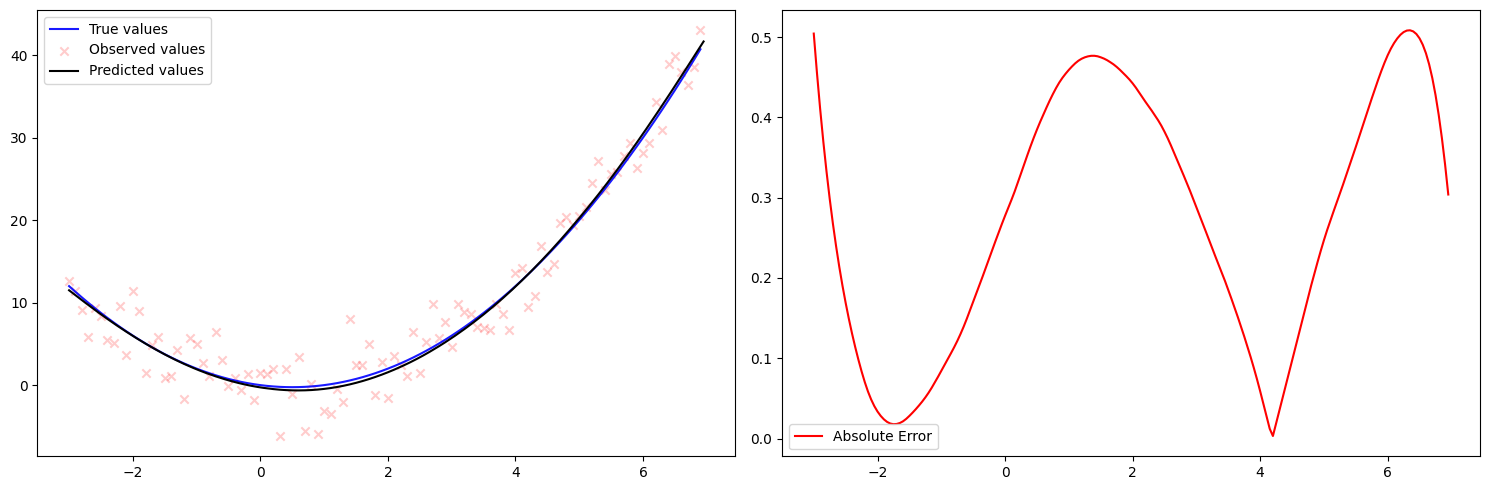

In [5]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15, 5))
ax1.plot(ts.flatten(), true_values.flatten(), label="True values", c="blue",alpha=0.9)
ax1.scatter(ts.flatten(), observed_values.flatten(), label="Observed values",  c="red",marker="x", alpha=0.2)
ax1.plot(fine_grid_times.flatten(), prediction, label="Predicted values", c="black")
ax1.legend()
ax2.plot(fine_grid_times.flatten(), (prediction-fine_grid_true_values.flatten()).abs(), label="Absolute Error", c="red")
ax2.legend()
plt.tight_layout()
plt.show()

Nice! we can see that even tho the data was quite noisy, we were able to learn a nice local representation to impute the missing values! Let"s quickly compute the root mean squared error before we move on to a more complicated example:

In [6]:
torch.sqrt(((prediction-fine_grid_true_values.flatten())**2).mean())

tensor(0.3176)

At this point it might be interesting to run the above code a few times, to get a feeling for how the imputed values change with the randomness in the data. After this one might also want to read the reported error bars and observed standard deviations in the accompanying paper {cite}`fim_dynamical_systems`.

## Using Batches and estimating standard deviations
If the data includes multiple evaluations of the same grid, we can estimate the standard deviations of our predicted values. For this we again prepare some data:

In [7]:
PARAMS={"a":1,"b":3}
N=100
ts_batch = torch.stack([(torch.arange(0, N*0.1, step=0.1) - 3).reshape(N, 1) for _ in range(10)],axis=0)
true_values_batch = PARAMS["a"]*torch.sin(PARAMS["b"]*ts_batch) + ts -0.5*ts_batch**2 
observed_values_batch = true_values_batch + torch.normal(0, 2.5, size=true_values_batch.shape)

In [8]:

fine_grid_times_batch=torch.stack([(torch.arange(0, N*0.1, step=0.05) - 3).reshape(2*N, 1) for _ in range(10)],axis=0)
fine_grid_true_values_batch = PARAMS["a"]*torch.sin(PARAMS["b"]*fine_grid_times_batch) + fine_grid_times_batch -fine_grid_times_batch**2  # To compare against while evaluating
batch=prepare_data_base(ts_batch,observed_values_batch,fine_grid_times=fine_grid_times_batch)
base_model.eval()
with torch.no_grad():
    prediction_batch = base_model(batch)["visualizations"]["solution"]["learnt"] # Shape [10, N, 1]

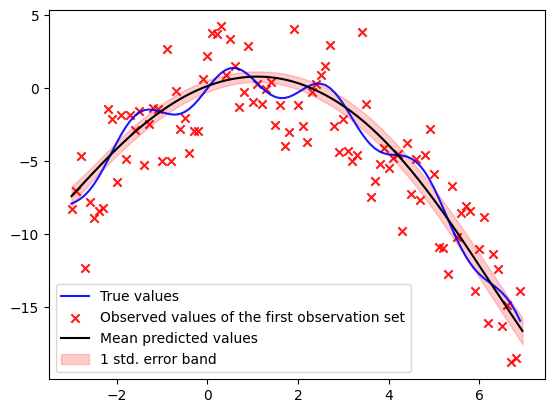

In [9]:
plt.plot(ts_batch[0].flatten(), true_values_batch[0].flatten(), label="True values", c="blue",alpha=0.9)
plt.scatter(ts_batch[0].flatten(), observed_values_batch[0].flatten(), label="Observed values of the first observation set", c="red",alpha=0.9,marker="x")
plt.plot(fine_grid_times_batch[0].flatten(), prediction_batch.mean(axis=0).flatten(), label="Mean predicted values", c="black")
plt.fill_between(fine_grid_times_batch[0].flatten(),prediction_batch.mean(axis=0).flatten()-prediction_batch.std(axis=0).flatten(),prediction_batch.mean(axis=0).flatten()+prediction_batch.std(axis=0).flatten(),color="red",alpha=0.2,label="1 std. error band")
plt.legend()
plt.show()

From this example we can not only see how to compute confidence bands of the model, but we also saw how robust the model can be to noise! 

:::{warning}
We have defined some PARAMETERS ```PARAMS``` above, which can be used to show the types of problems where this model can struggle. In particular, 
high frequency components, represented above by the sine function, can quickly become a problem, since the increasing these parameters weakens the assumed "locally simplicity" property of our data. The user can reproduce these problems by choosing large values like ```a=b=10```.
:::

:::{Note}
While the $\texttt{FIM}$ model does support independent dimensions directly, $\texttt{FIM}-\ell$ does not. You can solve this by either misusing the batch dimension for this or evaluate the model sequentially, i.e. one dimension after the other.
:::